In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import sklearn

from scipy.stats import randint
from sklearn import tree, svm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier, CatBoostRegressor, MetricVisualizer, Pool, cv
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.tree import export_text
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

df = pd.read_csv("./mental-heath-in-tech-2016_20161114.csv")

pd.set_option('max_colwidth', 300)
pd.set_option('max_columns', 70)

# Information

df.info() for overview

## Column Access

- Actual name (very long)
- by index via `iloc[:, i]`
- shorten the names of the columns
    
## Columns to be dropped

Check in code blocks below where the data gets analyzed and then columns with too many different answers get dropped.

**This changes the indeces!**

## Questions

0. Are you self-employed?
1. How many employees does your company or organization have? **[NaN]**
2. Is your employer primarily a tech company/organization? **[NaN]**
3. Is your primary role within your company related to tech/IT? **[NaN]**
4. Does your employer provide mental health benefits as part of healthcare coverage?
5. Do you know the options for mental health care available under your employer-provided coverage?
6. Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
7. Does your employer offer resources to learn more about mental health concerns and options for seeking help?
8. Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
9. If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:
10. Do you think that discussing a mental health disorder with your employer would have negative consequences? **[NaN]**
11. Do you think that discussing a physical health issue with your employer would have negative consequences? **[NaN]**
12. Would you feel comfortable discussing a mental health disorder with your coworkers? **[NaN]**
13. Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)? **[NaN]**
14. Do you feel that your employer takes mental health as seriously as physical health?
15. Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace? **[NaN]**
16. Do you have medical coverage (private insurance or state-provided) which includes treatment of  mental health issues? **[NaN]**
17. Do you know local or online resources to seek help for a mental health disorder? **[NaN]**
18. If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts? **[NaN]**
19. [FOLLOW-UP] If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively? **[NaN]**
20. If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees? **[NaN]**
21. [FOLLOW-UP] If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively? **[NaN]**
22. Do you believe your productivity is ever affected by a mental health issue? **[NaN]**
23. [FOLLOW-UP] If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue? **[NaN]**
24. Do you have previous employers?
25. Have your previous employers provided mental health benefits?
26. [FOLLOW-UP] Were you aware of the options for mental health care provided by your previous employers? **[NaN]**
27. Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?
28. Did your previous employers provide resources to learn more about mental health issues and how to seek help? **[NaN]**
29. Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?
30. Do you think that discussing a mental health disorder with previous employers would have negative consequences?
31. Do you think that discussing a physical health issue with previous employers would have negative consequences? (no I don't know option available/selected) **[NaN]**
32. Would you have been willing to discuss a mental health issue with your previous co-workers? **[NaN]**
33. Would you have been willing to discuss a mental health issue with your direct supervisor(s)?
34. Did you feel that your previous employers took mental health as seriously as physical health?
35. Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces? **[NaN]**
36. Would you be willing to bring up a physical health issue with a potential employer in an interview? **[NaN]**
37. [FREE TEXT] [FOLLOW-UP] Why or why not? **[NaN]**
38. Would you bring up a mental health issue with a potential employer in an interview? **[NaN]**
39. [FREE TEXT] [FOLLOW-UP] Why or why not? **[NaN]**
40. Do you feel that being identified as a person with a mental health issue would hurt your career? **[NaN]**
41. Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue? **[NaN]**
42. How willing would you be to share with friends and family that you have a mental illness? **[NaN]**
43. Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace? **[NaN]**
44. Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace? **[NaN]**
45. Do you have a family history of mental illness?
46. Have you had a mental health disorder in the past? **[NaN]**
47. Do you currently have a mental health disorder? **[NaN]**
48. [FOLLOW-UP] [MULTIPLE] If yes, what condition(s) have you been diagnosed with? **[NaN]**
49. [FOLLOW-UP] [MULTIPLE] If maybe, what condition(s) do you believe you have? **[NaN]**
50. Have you been diagnosed with a mental health condition by a medical professional? **[NaN]**
51. [FOLLOW-UP] [MULTIPLE] If so, what condition(s) were you diagnosed with? **[NaN]**
52. Have you ever sought treatment for a mental health issue from a mental health professional?
53. [FOLLOW-UP] If you have a mental health issue, do you feel that it interferes with your work when being treated effectively? **[NaN]**
54. [FOLLOW-UP] If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?
55. What is your age? [REMOVE 323, 3, 99 (?)]
56. What is your gender?
57. What country do you live in?
58. What US state or territory do you live in? **[NaN]**
59. What country do you work in?
60. What US state or territory do you work in? **[NaN]**
61. [MULTIPLE] Which of the following best describes your work position?
62. Do you work remotely?

# Data Preparing

Handle missing entries, drop unwanted data and encode everything to numbers.

In [3]:
# Drop unwanted data

# Drop all self-employed as we only want to analyze people in companies.
df = df.drop(df[(df.iloc[:,0] == 1)].index)

# Drop 24 - 35 because we want to analyze the answers related to their current job.
# Drop questions for only self-employed people
df = df.drop(df.columns[list(range(16, 24))], axis = 1)

# Check what columns have too many choices
for ind, column in enumerate(df.columns):
    if len(df.iloc[:, ind].value_counts()) > 20:
        print(ind, column)
        print('Different answers: ', len(df[column].value_counts()))

# 35, 36  stay, rest goes (after analyzing)
# Drop the rest [37, 39, 48, 49, 51, 58, 60, 61]:
# df = df.drop(df.columns[[17, 19, 28, 29, 31, 37, 38, 39, 40, 41]], axis = 1)

# if previous yes, self no
df = df.drop(df.columns[[29, 31, 40, 41, 43, 49, 50, 51, 52, 53]], axis = 1)

# Drop 3 because this survey is directed at people in IT and we just care about that.
df = df.drop(df[(df.iloc[:,3] == 0)].index)
df = df.drop(df.columns[[3]], axis = 1)

# Drop self-employed because all the same
df = df.drop(df.columns[[0]], axis = 1)

# almost empty
df = df.drop(["Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?"], axis=1)

29 Why or why not?
Different answers:  863
31 Why or why not?.1
Different answers:  860
40 If yes, what condition(s) have you been diagnosed with?
Different answers:  101
41 If maybe, what condition(s) do you believe you have?
Different answers:  77
43 If so, what condition(s) were you diagnosed with?
Different answers:  90
47 What is your age?
Different answers:  51
48 What is your gender?
Different answers:  61
49 What country do you live in?
Different answers:  43
50 What US state or territory do you live in?
Different answers:  47
51 What country do you work in?
Different answers:  44
52 What US state or territory do you work in?
Different answers:  48
53 Which of the following best describes your work position?
Different answers:  180


In [4]:
# Prepare Gender
male = ['Male', 'male', 'Male ', 'M', 'm', 'man', 'Cis male', 'Male.', 'Male. ', 'Male (cis)', 'Man', 'Sex is male',
        'cis male', 'Malr', 'Dude', 'mail', 'M|', 'male ', 'Cis Male', 'cisdude', 'cis man', 'MALE',
        "I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? "]
female = ['Female', 'female', 'I identify as female.', 'female ', 'Female assigned at birth ', 'F', 'Woman', 'f',
          'Cis female ', 'Female ', 'woman', 'female/woman', 'Cisgender Female', 'fem', 'Female (props for making this a freeform field, though)',
          ' Female', 'Cis-woman']
other = ['Bigender', 'non-binary', 'fm', 'Transitioned, M2F', 'Genderfluid (born female)', 'Other/Transfeminine',
         'Female or Multi-Gender Femme', 'Androgynous', 'male 9:1 female, roughly', 'Other', 'nb masculine',
         'none of your business', 'genderqueer', 'Human','Genderfluid', 'Enby','genderqueer woman', 'mtf', 'Queer',
         'Agender', 'Fluid', 'Male/genderqueer', 'Nonbinary', 'human', 'Unicorn', 'Male (trans, FtM)',
         'Genderqueer', 'Genderflux demi-girl', 'female-bodied; no feelings about gender', 'AFAB', 'Transgender woman', 'nan']

df["What is your gender?"].replace(male, 1, inplace=True)
df["What is your gender?"].replace(female, 2, inplace=True)
df["What is your gender?"].replace(other, 3, inplace=True)
df["What is your gender?"].fillna(3, inplace=True);

df["What is your gender?"].unique()

array([1., 2., 3.])

In [5]:
# Prepare Age 

# replace irregularities with mean age
mean = df["What is your age?"].mean()
mean = round(mean)
df.loc[(df["What is your age?"] < 15) | (df["What is your age?"] > 90),"What is your age?"] =  mean

counts = df["What is your age?"].value_counts()

scaler = MinMaxScaler()
df['What is your age?'] = scaler.fit_transform(df[['What is your age?']])

# age in groups and ordinal
# age_labels = ["17-25", "26-34", "35-44", "45-54", "over 55"]
# df["What is your age?"] = pd.cut(x=df['What is your age?'], bins=[0,25,34,44,54,100], labels=age_labels)
# age_group_mapper = {'17-25':1, '26-34':2, '35-44':3, '45-54':4, 'over 55':5}
# df["What is your age?"] = df["What is your age?"].replace(age_group_mapper)

In [6]:
# Clean Data
# Handle NaN (This is just an idea, doesn't need to be done 100%)
# might be useless as these may be self-employed nan's
# df.iloc[:, [4, 6, 7, 8, 9, 14, 25, 27, 29, 30, 34]] = df.iloc[:, [4, 6, 7, 8, 9, 14, 25, 27, 29, 30, 34]].fillna("I don't know")

# 44: Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?
# around 500 did not answer -> not applicable
# df["Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?"].fillna('n/a', inplace=True)

# Clean age by replacing the wrong ages with the mean value.


# We interpret the answer n/a here as no [4. Does your employer provide mental health benefits as part of healthcare coverage?]
# Everyone should be applicable here.
# df["Does your employer provide mental health benefits as part of healthcare coverage?"].replace('Not eligible for coverage / N/A', 'No', inplace=True)

# fillna here with maybe (TODO reevaluate) 
# df['obs_reveal'].fillna('Maybe', inplace=True)

In [7]:
# Functions for mappers
def get_mapper(values):
    for mapper in mapper_list:
        if compare_arrays(values, mapper):
            return mapper


def compare_arrays(arr1, arr2):
    count = 0
    for val in arr1:
        if val in arr2:
            count+=1
    if count == arr1.size:
        return True
    else:
        return False

In [8]:
# shorten column names
df = df.rename(columns = {'How many employees does your company or organization have?'
                          :'company_size'})
df = df.rename(columns = {'Is your employer primarily a tech company/organization?'
                          :'primarily_tech'})
df = df.rename(columns = {'Does your employer provide mental health benefits as part of healthcare coverage?'
                          :'empl_MH_healthcare'})
df = df.rename(columns = {'Do you know the options for mental health care available under your employer-provided coverage?'
                          :'empl_aware_MH_healthcare'})
df = df.rename(columns = {'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?'
                          :'disc_MH'})
df = df.rename(columns = {'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?'
                          :'obs_reveal'})
df = df.rename(columns = {'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?'
                          :'MH_interference_not_treated'})
df = df.rename(columns = {'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?'
                          :'MH_interference_treated'})
df = df.rename(columns = {'Does your employer offer resources to learn more about mental health concerns and options for seeking help?'
                          :'empl_res_for_MH'})
df = df.rename(columns = {'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?'
                          :'empl_anon'})
df = df.rename(columns = {'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:'
                          :'MH_asking_for_leave'})
df = df.rename(columns = {'Do you think that discussing a mental health disorder with your employer would have negative consequences?'
                          :'disc_MH_neg'})
df = df.rename(columns = {'Do you think that discussing a physical health issue with your employer would have negative consequences?'
                          :'disc_PH_neg'})
df = df.rename(columns = {'Would you feel comfortable discussing a mental health disorder with your coworkers?'
                          :'dis_MH_coworkers'})
df = df.rename(columns = {'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?'
                          :'disc_MH_supervisor'})
df = df.rename(columns = {'Do you feel that your employer takes mental health as seriously as physical health?'
                          :'empl_MH_serious_as_PH'})
df = df.rename(columns = {'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?'
                          :'neg_obs_cons_MH_coworker'})
df = df.rename(columns = {'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?'
                          :'neg_view_coworkers_MH'})
df = df.rename(columns = {'How willing would you be to share with friends and family that you have a mental illness?'
                          :'share_MH_framily'})
df = df.rename(columns = {'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?'
                          :'obs_bad_resp_MH'})
df = df.rename(columns = {'Have you ever sought treatment for a mental health issue from a mental health professional?'
                          :'sought_treatment'})
df = df.rename(columns = {'Would you be willing to bring up a physical health issue with a potential employer in an interview?'
                          :'PH_interview'})
df = df.rename(columns = {'Would you bring up a mental health issue with a potential employer in an interview?'
                          :'MH_interview'})
df = df.rename(columns = {'Do you have a family history of mental illness?'
                          :'MH_family'})
df = df.rename(columns = {'Have you had a mental health disorder in the past?'
                          :'MH_past'})
df = df.rename(columns = {'Do you currently have a mental health disorder?'
                          :'MH_currently'})
df = df.rename(columns = {'Have you been diagnosed with a mental health condition by a medical professional?'
                          :'diagnosed'})
df = df.rename(columns = {'What is your age?'
                          :'age'})
df = df.rename(columns = {'What is your gender?'
                          :'gender'})
df = df.rename(columns = {'Do you work remotely?'
                          :'remote'})

# prev employee
df = df.rename(columns = {'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?'
                          :'prev_anon'})


# 4,6,7,8: How serious does the company take MH
# provide_MH_healthcare, discussed_MH, employer_resources_options_for_MH, anonymity_protected
'''df["how_good_MH"] = df['provide_MH_healthcare'] + df['disc_MH'] + df['empl_res_MH'] + df['anon']
'''
# Very bad, bad, okay, good, very good

'''
how_good_MH_labels = ["Very Bad", "Bad", "Okay", "Good", "Very Good"]
df["how_good_MH"] = pd.cut(x=df["how_good_MH"], bins=[0,5,7,9,11,12], labels=how_good_MH_labels)
how_good_MH_mapper = {'Very Bad':1, 'Bad':2, 'Okay':3, 'Good':3, 'Very Good':4}
df["how_good_MH"] = df["how_good_MH"].replace(how_good_MH_mapper)
'''

# bad, good
'''
how_good_MH_labels = ["Bad", "Good"]
df["how_good_MH"] = pd.cut(x=df["how_good_MH"], bins=[0,7,12], labels=how_good_MH_labels)
how_good_MH_mapper = {'Bad':1, 'Good':2}
df["how_good_MH"] = df["how_good_MH"].replace(how_good_MH_mapper)
'''
'''
df = df.drop(columns=['provide_MH_healthcare', 'discussed_MH', 'employer_resources_options_for_MH', 'anonymity_protected'])
'''

"\ndf = df.drop(columns=['provide_MH_healthcare', 'discussed_MH', 'employer_resources_options_for_MH', 'anonymity_protected'])\n"

In [9]:
# make all features numerical

mapper_list = [{'No':1, 'Maybe':2, 'Yes':3}, {'No':1, 'I don\'t know':2, 'Yes':3}, {'No, it has not':1, 'No, I don\'t think it would':2,'Maybe':3, 'Yes, I think it would':4, 'Yes, it has':5},
               {'None of them':1,  'I don\'t know':3, 'Some of them':2, 'Yes, all of them':4}, {'None did':1, 'Some did':2, 'Yes, they all did':3}, 
               {'No':1, 'Maybe/Not sure':2, 'Yes, I observed':3, 'Yes, I experienced':4},
               {'N/A (not currently aware)':1, 'No, I only became aware later':2, 'I was aware of some':3, 'Yes, I was aware of all of them':4},
               {'No, they do not':1, 'No, I don\'t think they would':2, 'Maybe':3, 'Yes, I think they would':4, 'Yes, they do':5},
               {'Very difficult':1, 'Somewhat difficult':2, 'Neither easy nor difficult':3, 'Somewhat easy':4, 'Very easy':5, 'I don\'t know':3},
               {'Not open at all':1, 'Somewhat not open':2, 'Neutral':3, 'Not applicable to me (I do not have a mental illness)': -1, 'Somewhat open':4, 'Very open':5},
               {'Never':1, 'Sometimes':2, 'Always':3},
               {'No':1, "I'm not sure":2, 'Yes': 3},
               {'No, at none of my previous employers':1, 'I don\'t know': 2, 'Some of my previous employers':3, 'Yes, at all of my previous employers':4},
               {'None did':1, "I don't know":2, 'Some did':3,  'Yes, they all did':4},
               {'No, none did':1, "I don't know":2, 'Some did':3, 'Yes, they all did':4},
               {'None of them':1, "I don't know":2, 'Some of them':3, 'Yes, all of them':4},
               {'None did':1, 'Some did':2, 'Yes, they all did':3},
               {'No, none did':1, "I don't know":2, 'Some did':3, 'Yes, they all did':4},
               {'No, none did':1, "I don't know":2, 'Some did':3, 'Yes, they all did':4},
               {'No, at none of my previous employers':1, "I don't know":2, 'Some of my previous employers':3, 'Yes, at all of my previous employers':4},
               {'No':1, "I don't know":2, 'Sometimes':3, 'Yes, always':4},
               {'Never':1, 'Rarely':2, 'Not applicable to me':-1, 'Sometimes':3, 'Often':4},
               {'Never':1, 'Rarely':2, 'Sometimes':3, 'Often':4},
               {'No':1, 'I don\'t know':2, 'Yes':3, 'Not eligible for coverage / N/A': -1},
               {'No':1, "I am not sure":2, 'Yes': 3, 'nan': -1},
               {0:1, 1:2},
               {'1-5':1, '6-25':6, '26-100':26, '100-500':100, '500-1000':500, 'More than 1000':1000}]

# Haven't figured out why, but needs to be done twice   
for column in df:
    df[column] = df[column].replace(get_mapper(df[column].unique()))

for column in df:
    df[column] = df[column].replace(get_mapper(df[column].unique()))

# Fill al nan with -1 as not applicable (just one feature)
df = df.fillna('nan')

for column in df:
    df[column] = df[column].replace(get_mapper(df[column].unique()))


In [10]:
# For Plotting the decision Tree

# clf = tree.DecisionTreeClassifier(max_depth=3)
# clf = clf.fit(train_X,train_y)

# fig=plt.figure(figsize=(40, 40))
# tree.plot_tree(clf, fontsize=8, feature_names=list(X), filled=True)
# fig.savefig('decision_tree_plot.png', dpi=100)

In [11]:
def feature_importance(model, depth, score):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh', title='Depth: ' + str(depth) + ' Score: ' + str(score))

In [30]:
def tune_parameters(model, parameters, scoring):
    search = RandomizedSearchCV(model, parameters, n_iter=2000, cv=10, scoring=scoring, refit=True, n_jobs=-1)
    search.fit(X, y)

    print('best score: ', search.best_score_)
    print('best parameters: ', search.best_params_)

In [20]:
test_size = 0.25

# X and Y
y_interview = "MH_interview"
y_diagnose = "diagnosed"
y_treatment = "sought_treatment"
physical = "PH_interview"
high_affectors = ["MH_past", "MH_currently", "MH_interference_treated", "MH_interference_not_treated"]


X = df.drop([y_interview, y_diagnose, y_treatment, physical] + high_affectors, axis=1, inplace=False)
y = df[y_diagnose]

train_X , val_X , train_y , val_y = train_test_split(X, y, test_size = test_size)

In [31]:
featuresSize = len(X.columns)

scoring_clf = 'accuracy'
scoring_rgr = 'neg_mean_absolute_error'

param_dist_class = {
    "max_depth": randint(3,10),
    "max_features": randint(1, featuresSize),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20),
    "criterion": ["gini", "entropy"]}
param_dist_regressor = {
    "max_depth": randint(3,15),
    "max_features": randint(1, featuresSize),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20),
    "criterion": ["mse", "friedman_mse"]}

# rgr = tree.DecisionTreeRegressor()
# tune_parameters(rgr, param_dist_regressor, scoring_rgr)

clf = tree.DecisionTreeClassifier()
tune_parameters(clf, param_dist_class, scoring_clf)

best score:  0.7188790560471976
best parameters:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 30, 'min_samples_leaf': 10, 'min_samples_split': 11}


In [ ]:
maxdepth = 10

#Split into validation and training data
t_mae =[0]* maxdepth
v_mae =[0]* maxdepth

bestdepth = 1
best_model = None
bestscore = 0

min_samples_leaf = 3
min_samples_split = 6
criterion = 'entropy'
max_depth = 4
max_features = 17

for depth in range(1,maxdepth +1):
    # Specify Model
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    # FitModel
    clf.fit(train_X , train_y)
    # calculate mean absolute error on training instances 
    train_predictions = clf.predict(train_X)
    t_mae[depth - 1] = accuracy_score(train_predictions, train_y)
    # Make validation predictions and calculate mean absoluteerror
    val_predictions = clf.predict(val_X)
    v_mae[depth - 1] = accuracy_score(val_predictions, val_y)
    
    if(v_mae[depth - 1] >= v_mae[bestdepth - 1]):
        best_model = clf
        bestdepth = depth
        bestscore = v_mae[depth - 1]

t_mae = np.asarray(t_mae)
v_mae = np.asarray(v_mae)

plt.plot(range(1,maxdepth +1),t_mae ,c="blue")
plt.plot(range(1,maxdepth +1),v_mae ,c="red")
plt.xlabel('Depth')
plt.ylabel('Accuracy Score')
plt.title('Prediction of ' + y.name)

plt.show()

feature_importance(best_model, bestdepth, bestscore)
print("Score X Y")
best_model.score(X, y)

Score:
0.7223695844385499
Prediction Accuracy:
0.6749116607773852


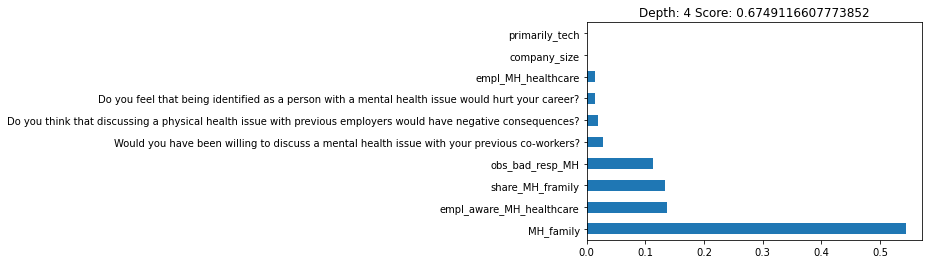

In [45]:
min_samples_leaf = 5
min_samples_split = 8
criterion = 'entropy'
max_depth = 4
max_features = 24

clf = tree.DecisionTreeClassifier(max_depth = max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, criterion=criterion)
# FitModel
clf.fit(train_X , train_y)
val_predictions = clf.predict(val_X)
score = accuracy_score(val_predictions, val_y)
feature_importance(clf, max_depth, score)
print("Score:")
print(clf.score(X, y))
print("Prediction Accuracy:")
print(score)

In [ ]:

featuresSize = len(X.columns)

maxdepth = 10
train_size=0.6
bestdepth = 1
bestscore = 0
# parameters
min_samples_leaf = 2
min_samples_split = 5
criterion = 'mse'
max_depth = 9
max_features = 21
# parameters classifier

#Split into validation and training data
t_mae =[0]* maxdepth
v_mae =[0]* maxdepth

for depth in range(1,maxdepth +1):
    # Specify Model
    rgr = tree.DecisionTreeRegressor(max_depth=depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, criterion=criterion)
    # FitModel
    rgr.fit(train_X , train_y)
    # calculate mean absolute error on training instances 
    train_predictions = rgr.predict(train_X)
    t_mae[depth - 1] = mean_absolute_error(train_predictions, train_y)
    # Make validation predictions and calculate mean absoluteerror
    val_predictions = rgr.predict(val_X)
    v_mae[depth - 1] = mean_absolute_error(val_predictions, val_y)
    
    if(v_mae[depth - 1] <= v_mae[bestdepth - 1]):
        best_model = rgr
        bestdepth = depth
        bestscore = v_mae[depth - 1]

t_mae = np.asarray(t_mae)
v_mae = np.asarray(v_mae)

plt.plot(range(1,maxdepth +1),t_mae ,c="blue")
plt.plot(range(1,maxdepth +1),v_mae ,c="red")
plt.xlabel('Depth')
plt.ylabel('MAE')
plt.title('Prediction of ' + y.name)

plt.show()

feature_importance(best_model, bestdepth, bestscore)

In [ ]:
# Output rules to txt
# tree_rules = export_text(clf, feature_names=list(X))

# text_file = open("Output.txt", "w")
# text_file.write(tree_rules)
# text_file.close()

In [ ]:
# Age plot (More of a template now)
# plt.figure(figsize=(15,8))
# plt.title("Age Distribution and Density")
# plt.xlabel("Age")
# plt.ylabel("Density")
# sns.distplot(df['What is your age?'])

In [ ]:
df_dummy.info()

In [ ]:
df['Have you ever sought treatment for a mental health issue from a mental health professional?'].unique()

In [ ]:
df['empl_aware_MH_healthcare'].unique()

0.9248452696728559

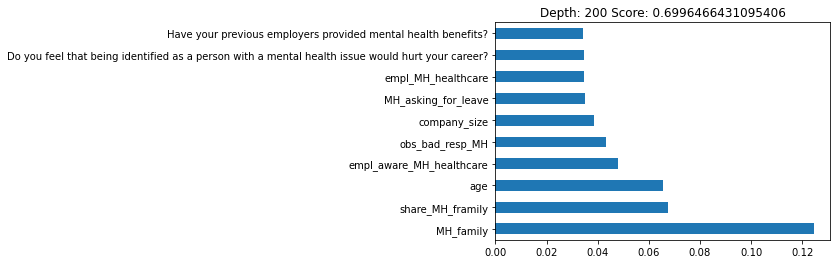

In [21]:
featuresSize = len(X.columns)
scoring_clf = 'accuracy'

param_dist_class = {
    "max_depth": randint(3,10),
    "max_features": randint(1, featuresSize),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 10),
    "criterion": ["gini", "entropy"]}

clf2 = RandomForestClassifier(n_estimators=200, random_state=42)  
# tune_parameters(clf2, param_dist_class, scoring_clf)
clf2.fit(train_X, train_y)  
val_predictions = clf2.predict(val_X)
score = accuracy_score(val_predictions, val_y)
feature_importance(clf2, 200, score)
clf2.score(X, y)

In [ ]:
for column in df_dummy:
    print(column)
    print(df[column].unique())

## Questions

0. Are you self-employed?
1. How many employees does your company or organization have? **[NaN]**
2. Is your employer primarily a tech company/organization? **[NaN]**
3. Is your primary role within your company related to tech/IT? **[NaN]**
4. Does your employer provide mental health benefits as part of healthcare coverage?
5. Do you know the options for mental health care available under your employer-provided coverage?
6. Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
7. Does your employer offer resources to learn more about mental health concerns and options for seeking help?
8. Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
9. If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:
10. Do you think that discussing a mental health disorder with your employer would have negative consequences?
11. Do you think that discussing a physical health issue with your employer would have negative consequences?
12. Would you feel comfortable discussing a mental health disorder with your coworkers?
13. Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?
14. Do you feel that your employer takes mental health as seriously as physical health?
15. Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?
36. Would you be willing to bring up a physical health issue with a potential employer in an interview?
38. Would you bring up a mental health issue with a potential employer in an interview? **[NaN]**
40. Do you feel that being identified as a person with a mental health issue would hurt your career? **[NaN]**
41. Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue? **[NaN]**
42. How willing would you be to share with friends and family that you have a mental illness? **[NaN]**
43. Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace? **[NaN]**
44. Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace? **[NaN]**
45. Do you have a family history of mental illness?
46. Have you had a mental health disorder in the past? **[NaN]**
47. Do you currently have a mental health disorder? **[NaN]**
50. Have you been diagnosed with a mental health condition by a medical professional? **[NaN]**
52. Have you ever sought treatment for a mental health issue from a mental health professional?
53. [FOLLOW-UP] If you have a mental health issue, do you feel that it interferes with your work when being treated effectively? **[NaN]**
54. [FOLLOW-UP] If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?
55. What is your age?
56. What is your gender?
62. Do you work remotely?